# Prepare the Training and Testing Data Sets

First, we must load the data sets using the load_data_from_df function from transformer.py and then we will construct the data loader using the construct_loader, also from transformer.py. This notebook assumes you are running the model from the main section of this github repository, however we do set the current working directory to the soltrannet directory.

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import time

os.chdir('soltrannet')

from soltrannet.quantum_data_utils import load_data_from_df, construct_loader

Setting the specified random seed

In [2]:
trainfile = 'Training_Data/train_subset1_1000.csv' 
testfile = 'Testing_Data/test_subset1_1000.csv' 

torch.manual_seed(420)
np.random.seed(420)

Loading the Training & Testing Data

In [3]:
batch_size = 8

trainX, trainy = load_data_from_df(trainfile, add_dummy_node=True, one_hot_formal_charge=True)
data_loader = construct_loader(trainX, trainy, batch_size)

testX, testy = load_data_from_df(testfile, add_dummy_node=True, one_hot_formal_charge=True)
testdata_loader = construct_loader(testX, testy, batch_size)

C:\Users\Brett\brett.ondich\SolTranNet_test\soltrannet\quantum_data_utils.py:122: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='Q_Data/B-1384.csv' mode='r' encoding='cp1252'>"
  qarray = np.loadtxt(q_data, delimiter=',', skiprows=1, usecols=(4,5,6,7))
REASON: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)
REASON: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 14 and the array at index 1 has size 17
C:\Users\Brett\brett.ondich\SolTranNet_test\soltrannet\quantum_data_utils.py:122: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='Q_Data/B-1260.csv' mode='r' encoding='cp1252'>"
  qarray = np.loadtxt(q_data, delimiter=',', skiprows=1, usecols=(4,5,6,7))
REASON: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array

# Prepare Model

The model parameters used below are the default values used for the SolTranNet architecture.

In [4]:
from transformer import make_model

In [5]:
d_atom = trainX[0][0].shape[1] # It depends on the used featurization. To match 
                                #SolTranNet architecture d_atom should equal 28

model_params = {
    'd_atom': d_atom,
    'd_model': 8,
    'N': 8,
    'h': 2,
    'N_dense': 1,
    'lambda_attention': 0.33, 
    'leaky_relu_slope': 0.0, 
    'dense_output_nonlinearity': 'relu', 
    'dropout': 0.1,
    'aggregation_type': 'mean'
}


In [6]:
model = make_model(**model_params)

In [7]:
model.train()

GraphTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
            (1): Linear(in_features=8, out_features=8, bias=True)
            (2): Linear(in_features=8, out_features=8, bias=True)
            (3): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=8, out_features=8, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.1, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
   

In [8]:
#Setting up the loss function

criterion = torch.nn.MSELoss(reduction='mean')

In [9]:
#Selecting Optimizer

optimizer=torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9,weight_decay=0)

# Run Training/Evaluation Loop

In [10]:
iteration = 0
for epoch in range(10):
    epoch_preds=np.array([])
    epoch_gold=np.array([])
    for batch in data_loader:
        iteration+=1
        optimizer.zero_grad()
        adjacency_matrix, node_features, y = batch
        batch_mask = torch.sum(torch.abs(node_features), dim=-1) !=0
        y_pred = model(node_features, batch_mask, adjacency_matrix, None)
        
        #accumulate the epoch training datas
        epoch_gold=np.append(epoch_gold,y.tolist())
        epoch_preds=np.append(epoch_preds,y_pred.tolist())
        
        loss=criterion(y_pred,y)
        
        loss.backward()
        
        #implementing gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),2)
        
        optimizer.step()
        
        if iteration%100==0:
            #we evaluate the test set
            model.eval()
            gold=np.array([])
            preds=np.array([])
            
            for t_batch in testdata_loader:
                t_adjacency_matrix, t_node_features, t_y = t_batch
                gold=np.append(gold,t_y.tolist())
                t_batch_mask = torch.sum(torch.abs(t_node_features), dim=-1) !=0
                t_y_pred = model(t_node_features, t_batch_mask, t_adjacency_matrix, None)
                preds=np.append(preds,t_y_pred.tolist())
            
            test_rmse=np.sqrt(np.mean((preds-gold)**2))
            test_r2=np.corrcoef(preds,gold)[0][1]**2
            model.train()

    #end of 1 epoch -- time to log the stats
    
    #print(epoch_preds)
    #print(epoch_gold)
    train_rmse = (np.sqrt(np.mean((epoch_preds-epoch_gold)**2))) 
    train_r2 = np.corrcoef(epoch_preds,epoch_gold)[0][1]**2
    
    print(f'----------------------------------')
    print(f'Epoch: {epoch}')
    print(f'Training RMSE: {train_rmse}')
    print(f'Training R2: {train_r2}')
    #print(f'Test RMSE: {test_rmse}')
    #print(f'Test R2: {test_r2}')

C:\Users\Brett\brett.ondich\SolTranNet_test\soltrannet\quantum_data_utils.py:279: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  return [FloatTensor(features) for features in (adjacency_list, features_list, labels)]


----------------------------------
Epoch: 0
Training RMSE: 3.4380740847852382
Training R2: 0.00046407734168221423
----------------------------------
Epoch: 1
Training RMSE: 2.927300804068996
Training R2: 0.005871059777063671
----------------------------------
Epoch: 2
Training RMSE: 2.6367653767142016
Training R2: 0.013404795636915368
----------------------------------
Epoch: 3
Training RMSE: 2.4779018932467705
Training R2: 0.017602850108591327
----------------------------------
Epoch: 4
Training RMSE: 2.400205816753407
Training R2: 0.0772052521341173
----------------------------------
Epoch: 5
Training RMSE: 2.3768144625673098
Training R2: 0.08806606308210595
----------------------------------
Epoch: 6
Training RMSE: 2.366855199935978
Training R2: 0.1137411617480566
----------------------------------
Epoch: 7
Training RMSE: 2.360941814635478
Training R2: 0.10431115445305784
----------------------------------
Epoch: 8
Training RMSE: 2.3519494134675156
Training R2: 0.13089715051484302
-

In [11]:
torch.save(model.state_dict(),'trained.model')

In [12]:
model.eval()

gold=np.array([])
preds=np.array([])
t0=time.time()
train_times=[]

for batch in data_loader:
    t1=time.time()
    adjacency_matrix, node_features, y = batch
    tload=time.time()-t1
    gold=np.append(gold,y)
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    y_pred = model(node_features, batch_mask, adjacency_matrix, None)
    tpred=time.time()-t1
    preds=np.append(preds,y_pred.tolist())
    
    train_times.append((tload,tpred))
    
ttime=time.time()-t0
print('Overall Time: ',ttime)

Overall Time:  3.1721813678741455


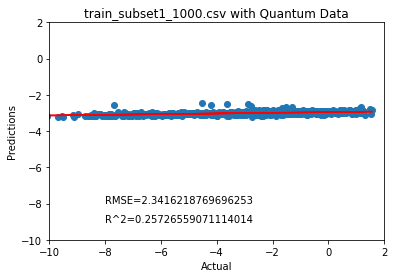

-3.037956317187048
-3.010515123455968
Train RMSE: 2.3416218769696253
Train R2 : 0.25726559071114014


In [13]:
r2=np.corrcoef(preds,gold)[0][1]**2
rmse=np.sqrt(np.mean((preds-gold)**2))

import matplotlib.pyplot as plt

plt.scatter(gold,preds)
z = np.polyfit(gold, preds, 1)
p = np.poly1d(z)
plt.plot(gold, p(gold), color='r')
plt.xlim([-10,2])
plt.ylim([-10,2])
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.title('%s with Quantum Data'%trainfile[14:])
plt.text(-8, -8, r'RMSE=%s'%rmse)
plt.text(-8, -9, r'R^2=%s'%r2)
plt.savefig('With_QData_%s.png'%trainfile[14:])
plt.show()

goldavg = np.mean(gold)
print(goldavg)
predavg = np.mean(preds)
print(predavg)
print('Train RMSE:',rmse)
print('Train R2 :',r2)

Overall Time:  0.963447093963623


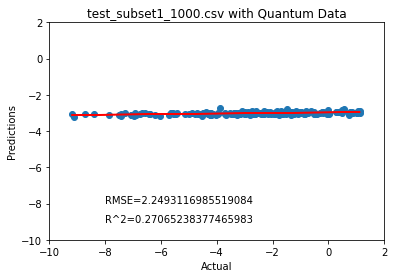

Test RMSE: 2.2493116985519084
Test R2  : 0.27065238377465983


In [14]:
#evaluate the test_set

gold=np.array([])
preds=np.array([])
t0=time.time()
test_times=[]
for batch in testdata_loader:
    t1=time.time()
    adjacency_matrix, node_features, y = batch
    tload=time.time()-t1
    gold=np.append(gold,y.tolist())
    batch_mask = torch.sum(torch.abs(node_features), dim=-1) != 0
    y_pred = model(node_features, batch_mask, adjacency_matrix, None)
    tpred=time.time()-t1
    preds=np.append(preds,y_pred.tolist())


    test_times.append((tload,tpred))

ttime=time.time()-t0
print('Overall Time: ',ttime)

r2=np.corrcoef(preds,gold)[0][1]**2
rmse=np.sqrt(np.mean((preds-gold)**2))

plt.scatter(gold,preds)
z = np.polyfit(gold, preds, 1)
p = np.poly1d(z)
plt.plot(gold, p(gold), color='r')
plt.xlim([-10,2])
plt.ylim([-10,2])
plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.title('%s with Quantum Data'%testfile[13:])
plt.text(-8, -8, r'RMSE=%s'%rmse)
plt.text(-8, -9, r'R^2=%s'%r2)
plt.savefig('With_QData_%s.png'%testfile[13:])
plt.show()
average = np.mean(gold)

print('Test RMSE:',rmse)
print('Test R2  :',r2)

Try using Captum to see what is happening in the model